<a href="https://colab.research.google.com/github/chang-heekim/Oxford-Pet-Dataset/blob/main/Oxford_Pet_Dataset_Semantic_Segmenatiation_3_Class_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Necessary Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from glob import glob
from datetime import datetime
import cv2

from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from PIL import Image
import torch

from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch import nn, optim
from torchsummary import summary
import torch.nn.functional as F

# Setting Device & Prerprocessing Dataset

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device 

'cuda'

In [3]:
df = pd.read_csv('/content/drive/MyDrive/dataset/oxford_pet/annotations/list.txt', skiprows=6, delimiter=' ', header=None)
df.columns = ['file_name', 'id', 'species', 'breed']
df.head()

file_name  id  species  breed
0  Abyssinian_100   1        1      1
1  Abyssinian_101   1        1      1
2  Abyssinian_102   1        1      1
3  Abyssinian_103   1        1      1
4  Abyssinian_104   1        1      1

In [4]:
image_dir = '/content/drive/MyDrive/dataset/oxford_pet/images/'
mask_dir = '/content/drive/MyDrive/dataset/oxford_pet/annotations/trimaps/'

In [5]:
image_files = glob(image_dir + '*.jpg')
mask_files = glob(mask_dir + '*.png')
len(image_files), len(mask_files)

(7378, 7390)

In [6]:
mask_path = []
i = 0
for idx, img_file in enumerate(image_files):
    mask = img_file.replace(image_dir, mask_dir).replace('jpg', 'png')
    if mask in mask_files:
        mask_path.append(mask)
    else:
        image_files.pop(idx - i)
        i += 1

len(image_files), len(mask_path)

(7378, 7378)

In [7]:
image_files[:10], mask_path[:10]

(['/content/drive/MyDrive/dataset/oxford_pet/images/shiba_inu_12.jpg',
  '/content/drive/MyDrive/dataset/oxford_pet/images/wheaten_terrier_137.jpg',
  '/content/drive/MyDrive/dataset/oxford_pet/images/Bengal_88.jpg',
  '/content/drive/MyDrive/dataset/oxford_pet/images/keeshond_170.jpg',
  '/content/drive/MyDrive/dataset/oxford_pet/images/newfoundland_107.jpg',
  '/content/drive/MyDrive/dataset/oxford_pet/images/japanese_chin_106.jpg',
  '/content/drive/MyDrive/dataset/oxford_pet/images/Birman_49.jpg',
  '/content/drive/MyDrive/dataset/oxford_pet/images/Sphynx_90.jpg',
  '/content/drive/MyDrive/dataset/oxford_pet/images/Persian_126.jpg',
  '/content/drive/MyDrive/dataset/oxford_pet/images/japanese_chin_105.jpg'],
 ['/content/drive/MyDrive/dataset/oxford_pet/annotations/trimaps/shiba_inu_12.png',
  '/content/drive/MyDrive/dataset/oxford_pet/annotations/trimaps/wheaten_terrier_137.png',
  '/content/drive/MyDrive/dataset/oxford_pet/annotations/trimaps/Bengal_88.png',
  '/content/drive/MyDr

# Define Dataset Function & Visualization Dataset

In [8]:
class Oxford_Segmentation_Dataset(Dataset):
    def __init__(self, img_dir, mask_path, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.mask_path = mask_path
        
    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):
        img_path = self.img_dir[idx]
        image = Image.open(img_path)
        mask_path = self.mask_path[idx]
        mask = np.array(Image.open(mask_path))
        mask -= 1
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)
            mask = np.array(mask)
            mask = torch.tensor(mask).type(torch.LongTensor)

        return image, mask

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

target_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
])

dataset = Oxford_Segmentation_Dataset(
    img_dir=image_files, 
    mask_path=mask_path, 
    transform=transform, 
    target_transform=target_transform
)

train_size = int(len(dataset) * 0.9)
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [10]:
train_batch_size = 32
val_batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=2)

In [11]:
for idx, sample_batch in enumerate(train_loader):
    print(sample_batch[0].shape)
    print(sample_batch[1].shape)
    print(sample_batch[0].dtype)
    print(sample_batch[1].dtype)
    print()
    break

torch.Size([32, 3, 224, 224])
torch.Size([32, 224, 224])
torch.float32
torch.int64



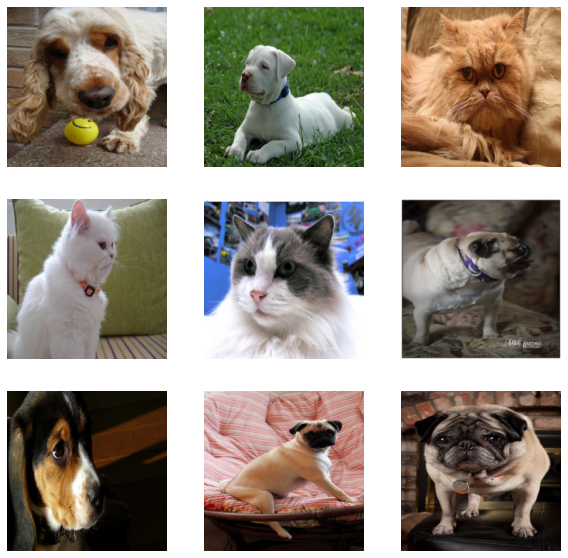

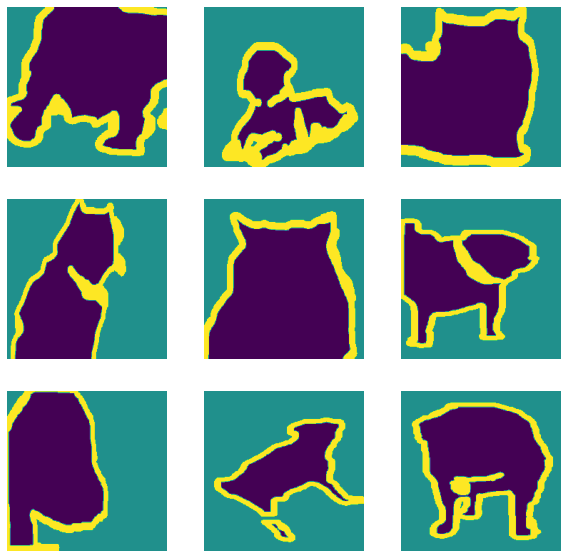

In [12]:
sample = next(iter(val_loader))
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(torch.permute(sample[0][i], (1, 2, 0)))
    plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(torch.squeeze(sample[1][i], 0))
    plt.axis('off')
plt.show()

# Implementation UNet

In [13]:
class DConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.dconv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.dconv(x)


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.max_pool = nn.MaxPool2d(2)

        self.enc1 = DConv(in_channels, 64)
        self.enc2 = DConv(64, 128)
        self.enc3 = DConv(128, 256)
        self.enc4 = DConv(256, 512)
        
        self.enc5 = nn.Conv2d(512, 1024, 3, 1, 1)
        self.dec5 = nn.Conv2d(1024, 512, 3, 1, 1)

        self.up_pool_4 = nn.ConvTranspose2d(512, 512, 2, 2, 0)
        self.dec4 = DConv(1024, 512)

        self.up_pool_3 = nn.ConvTranspose2d(512, 256, 2, 2, 0)
        self.dec3 = DConv(512, 256)

        self.up_pool_2 = nn.ConvTranspose2d(256, 128, 2, 2, 0)
        self.dec2 = DConv(256, 128)

        self.up_pool_1 = nn.ConvTranspose2d(128, 64, 2, 2, 0)
        self.dec1 = DConv(128, 64)

        self.conv = nn.Conv2d(64, out_channels, 1, 1, 0)
        
    def forward(self, x):
        enc1 = self.enc1(x)
        pool1 = self.max_pool(enc1)
        enc2 = self.enc2(pool1)
        pool2 = self.max_pool(enc2)
        enc3 = self.enc3(pool2)
        pool3 = self.max_pool(enc3)
        enc4 = self.enc4(pool3)
        pool4 = self.max_pool(enc4)
        
        enc5 = self.enc5(pool4)
        dec5 = self.dec5(enc5)

        up_pool4 = self.up_pool_4(dec5)
        cat4 = torch.cat((up_pool4, enc4), dim=1)
        dec4 = self.dec4(cat4)

        up_pool3 = self.up_pool_3(dec4)
        cat3 = torch.cat((up_pool3, enc3), dim=1)
        dec3 = self.dec3(cat3)

        up_pool2 = self.up_pool_2(dec3)
        cat2 = torch.cat((up_pool2, enc2), dim=1)
        dec2 = self.dec2(cat2)

        up_pool1 = self.up_pool_1(dec2)
        cat1 = torch.cat((up_pool1, enc1), dim=1)
        dec1 = self.dec1(cat1)

        out = self.conv(dec1)

        return out

# Define Iou & Dice Loss Function

In [14]:
def iou(preds, targets):
    smooth = 1e-5

    preds = preds.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()

    intersection = np.sum(np.logical_and(targets, preds))
    union = np.sum(np.logical_or(targets, preds))
    iou_score = (torch.tensor(intersection) + smooth)  / (torch.tensor(union) + smooth)

    return iou_score

def dice_coef(preds, targets):
    smooth = 1e-5

    preds = preds.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    targets = np.expand_dims(targets, 1)
    
    intersection = np.sum(np.logical_and(targets, preds))
    union = np.sum(np.logical_or(targets, targets)) + np.sum(np.logical_or(preds, preds))
    dice = (2 * torch.tensor(intersection) + smooth) / (torch.tensor(union) + smooth )
    return dice
    

def dice_loss(preds, targets):
    return 1 - dice_coef(preds, targets)

def bce_dice_loss(preds, targets):
    loss_fn = nn.CrossEntropyLoss()
    loss = 1. * loss_fn(preds, targets) + 1. * dice_loss(preds, targets)

    return loss

# Setting Model & Optimizer & Loss Function

In [15]:
lr = 1e-2
epochs = 30

model = UNet(3, 3).to(device)
model_name = type(model).__name__
summary(model, (3, 224, 224))

loss_fn = bce_dice_loss

optimizer = optim.Adam(model.parameters(), lr=lr)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,864
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
             DConv-7         [-1, 64, 224, 224]               0
         MaxPool2d-8         [-1, 64, 112, 112]               0
            Conv2d-9        [-1, 128, 112, 112]          73,728
      BatchNorm2d-10        [-1, 128, 112, 112]             256
             ReLU-11        [-1, 128, 112, 112]               0
           Conv2d-12        [-1, 128, 112, 112]         147,456
      BatchNorm2d-13        [-1, 128, 112, 112]             256
             ReLU-14        [-1, 128, 1

In [16]:
# With some modifications, source is from https://github.com/Bjarten/early-stopping-pytorch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.ckpt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.ckpt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        
        filename = self.path.split('/')[-1]
        save_dir = os.path.dirname(self.path)
        torch.save(model, os.path.join(save_dir, f"val_loss-{val_loss}-{filename}"))
        self.val_loss_min = val_loss

# Define Training & Validation Function

In [17]:
def train(epoch, model, train_loader, loss_fn, optimizer):
    print(f' Epoch: [{epoch}/{epochs}] - Train')
    model.train()
    current_loss = 0.0
    current_iou = 0.0
    for batch_idx, (images, mask) in enumerate(train_loader):
        images, mask = images.to(device), mask.to(device)

        outputs = model(images)

        loss = loss_fn(outputs, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)

        current_loss += loss.item()
        current_iou += iou(preds, mask)

        if (batch_idx + 1) % 50 == 0:
            train_loss = current_loss / 50
            train_iou = current_iou / 50
            print(f'Current Step: {batch_idx + 1} \tTrain Loss: {train_loss}, Train Iou: {train_iou}')

            current_loss = 0.0
            current_iou = 0.0

    return train_loss, train_iou

def validation(epoch, model, val_loader, loss_fn):
    print(f' Epoch: [{epoch}/{epochs}] - Validation')
    with torch.no_grad():
        model.eval()
        val_loss = 0.0
        val_iou = 0.0
        for val_idx, (val_images, val_mask) in enumerate(val_loader):

            val_images, val_mask = val_images.to(device), val_mask.to(device)
            val_outputs = model(val_images)

            val_loss += loss_fn(val_outputs, val_mask)
            
            _, val_preds = torch.max(val_outputs, 1)

            val_iou += iou(val_preds, val_mask)

        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_iou = val_iou / len(val_loader)

    print(f'Validation step: Val Loss: {val_epoch_loss}, Val Iou: {val_epoch_iou}')

    plt.figure(figsize=(15, 15))
    plt.subplot(131)
    plt.imshow(torch.permute(val_images[0], (1, 2, 0)).detach().cpu().numpy())
    plt.title('Image')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(val_mask[0].detach().cpu().numpy())
    plt.title('Mask')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(val_preds[0].detach().cpu().numpy())
    plt.title('Predict')
    plt.axis('off')
    plt.show()

    return val_epoch_loss, val_epoch_iou

In [18]:
log_dir = f"runs/{datetime.now().isoformat(timespec='seconds')}-{model_name}"
model_path = os.path.join(log_dir, 'models')
os.makedirs(model_path, exist_ok=True)

# Training

 Epoch: [1/30] - Train
Current Step: 50 	Train Loss: 0.6952489829063415, Train Iou: 0.6709396243095398
Current Step: 100 	Train Loss: 0.5974380958080292, Train Iou: 0.7141522765159607
Current Step: 150 	Train Loss: 0.5872647392749787, Train Iou: 0.7237899899482727
Current Step: 200 	Train Loss: 0.5395857048034668, Train Iou: 0.7430322170257568
 Epoch: [1/30] - Validation
Validation step: Val Loss: 0.7201129794120789, Val Iou: 0.7210168838500977


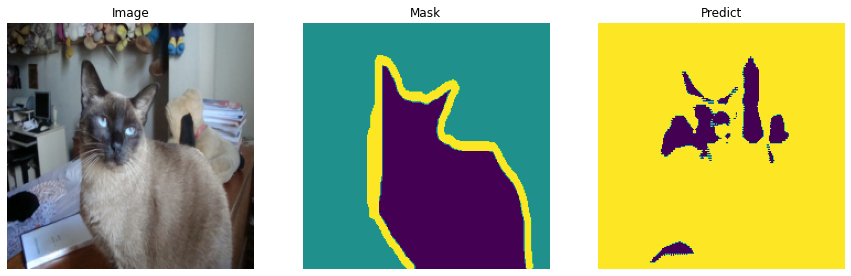

Validation loss decreased (inf --> 0.720113).  Saving model ...
 Epoch: [2/30] - Train
Current Step: 50 	Train Loss: 0.5507774019241333, Train Iou: 0.7379040718078613
Current Step: 100 	Train Loss: 0.5362860655784607, Train Iou: 0.7456777691841125
Current Step: 150 	Train Loss: 0.5006725490093231, Train Iou: 0.7591156959533691
Current Step: 200 	Train Loss: 0.47674471259117124, Train Iou: 0.7685859203338623
 Epoch: [2/30] - Validation
Validation step: Val Loss: 0.5590007901191711, Val Iou: 0.7587215900421143


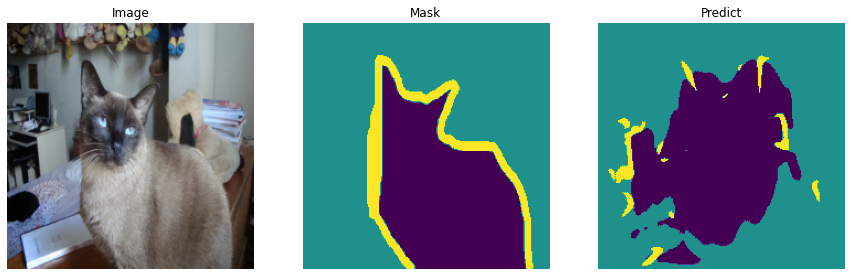

Validation loss decreased (0.720113 --> 0.559001).  Saving model ...
 Epoch: [3/30] - Train
Current Step: 50 	Train Loss: 0.4592126953601837, Train Iou: 0.7750617265701294
Current Step: 100 	Train Loss: 0.43638893842697146, Train Iou: 0.786611020565033
Current Step: 150 	Train Loss: 0.4365513253211975, Train Iou: 0.7892028093338013
Current Step: 200 	Train Loss: 0.4145155638456345, Train Iou: 0.7952028512954712
 Epoch: [3/30] - Validation
Validation step: Val Loss: 0.5525475740432739, Val Iou: 0.7235118746757507


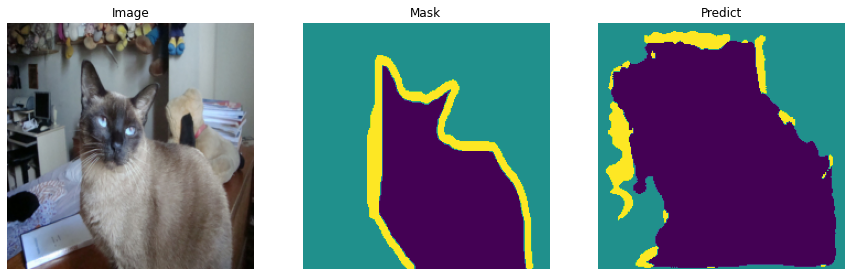

Validation loss decreased (0.559001 --> 0.552548).  Saving model ...
 Epoch: [4/30] - Train
Current Step: 50 	Train Loss: 0.40567279517650606, Train Iou: 0.8002018928527832
Current Step: 100 	Train Loss: 0.3827770107984543, Train Iou: 0.8084231019020081
Current Step: 150 	Train Loss: 0.38429812908172606, Train Iou: 0.808128297328949
Current Step: 200 	Train Loss: 0.3670149564743042, Train Iou: 0.815345287322998
 Epoch: [4/30] - Validation
Validation step: Val Loss: 0.429577112197876, Val Iou: 0.7869320511817932


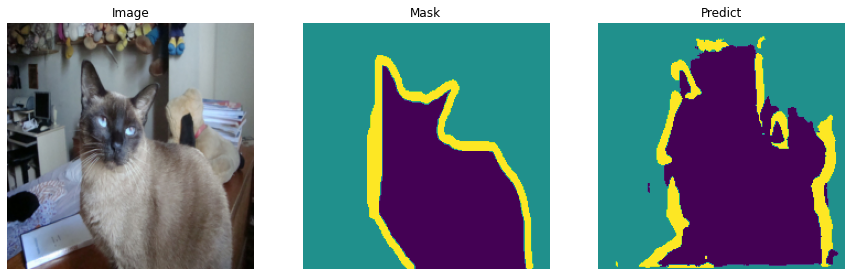

Validation loss decreased (0.552548 --> 0.429577).  Saving model ...
 Epoch: [5/30] - Train
Current Step: 50 	Train Loss: 0.36301240682601926, Train Iou: 0.8161086440086365
Current Step: 100 	Train Loss: 0.3534025478363037, Train Iou: 0.8203308582305908
Current Step: 150 	Train Loss: 0.3522295480966568, Train Iou: 0.8218405246734619
Current Step: 200 	Train Loss: 0.33152239084243773, Train Iou: 0.8297309875488281
 Epoch: [5/30] - Validation
Validation step: Val Loss: 0.3718870282173157, Val Iou: 0.8334949016571045


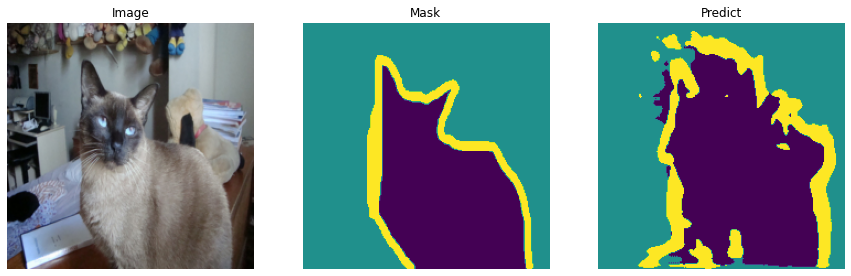

Validation loss decreased (0.429577 --> 0.371887).  Saving model ...
 Epoch: [6/30] - Train
Current Step: 50 	Train Loss: 0.30751005828380584, Train Iou: 0.8362249135971069
Current Step: 100 	Train Loss: 0.31042792975902556, Train Iou: 0.8342481851577759
Current Step: 150 	Train Loss: 0.31604416787624356, Train Iou: 0.837125301361084
Current Step: 200 	Train Loss: 0.32867289662361143, Train Iou: 0.8364700078964233
 Epoch: [6/30] - Validation
Validation step: Val Loss: 0.33028459548950195, Val Iou: 0.8315867781639099


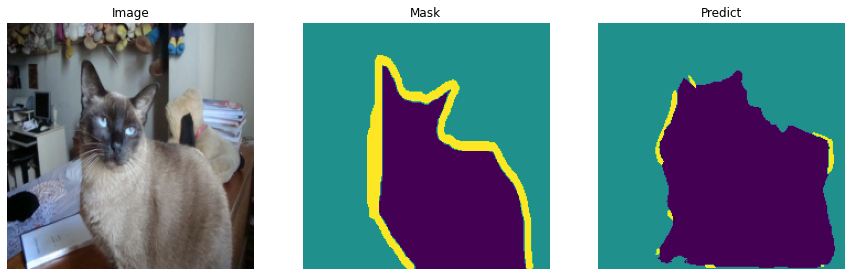

Validation loss decreased (0.371887 --> 0.330285).  Saving model ...
 Epoch: [7/30] - Train
Current Step: 50 	Train Loss: 0.29756960809230804, Train Iou: 0.8420803546905518
Current Step: 100 	Train Loss: 0.29068874299526215, Train Iou: 0.8464186787605286
Current Step: 150 	Train Loss: 0.29498778879642484, Train Iou: 0.8460270762443542
Current Step: 200 	Train Loss: 0.27607442378997804, Train Iou: 0.8516228199005127
 Epoch: [7/30] - Validation
Validation step: Val Loss: 0.30262890458106995, Val Iou: 0.8565683364868164


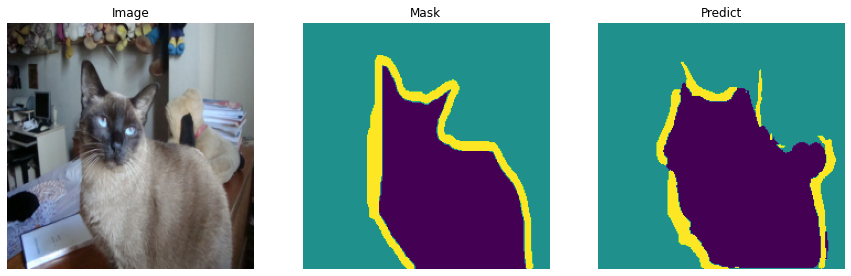

Validation loss decreased (0.330285 --> 0.302629).  Saving model ...
 Epoch: [8/30] - Train
Current Step: 50 	Train Loss: 0.276999351978302, Train Iou: 0.8540502786636353
Current Step: 100 	Train Loss: 0.27164955556392667, Train Iou: 0.8531216382980347
Current Step: 150 	Train Loss: 0.27039823472499847, Train Iou: 0.85544753074646
Current Step: 200 	Train Loss: 0.2410297304391861, Train Iou: 0.8664191961288452
 Epoch: [8/30] - Validation
Validation step: Val Loss: 0.37759581208229065, Val Iou: 0.8296692967414856


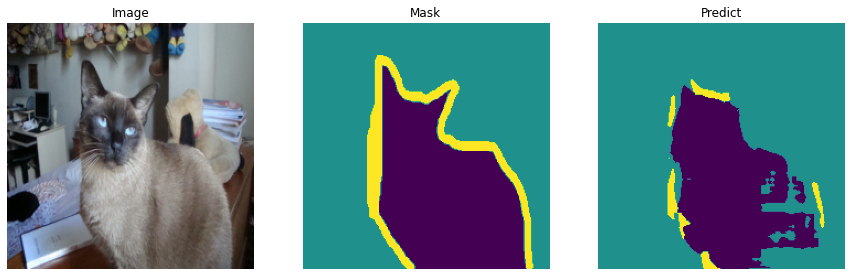

EarlyStopping counter: 1 out of 7
 Epoch: [9/30] - Train
Current Step: 50 	Train Loss: 0.25460758686065676, Train Iou: 0.8617742657661438
Current Step: 100 	Train Loss: 0.2543912470340729, Train Iou: 0.8607758283615112
Current Step: 150 	Train Loss: 0.23867778360843658, Train Iou: 0.8698381185531616
Current Step: 200 	Train Loss: 0.2460511475801468, Train Iou: 0.8646281361579895
 Epoch: [9/30] - Validation
Validation step: Val Loss: 0.29490700364112854, Val Iou: 0.8581722378730774


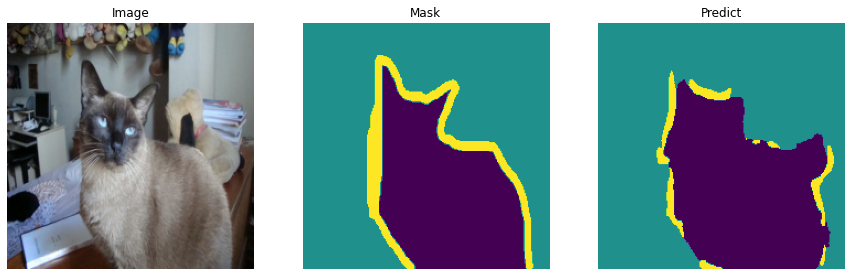

Validation loss decreased (0.302629 --> 0.294907).  Saving model ...
 Epoch: [10/30] - Train
Current Step: 50 	Train Loss: 0.22936000168323517, Train Iou: 0.8695034980773926
Current Step: 100 	Train Loss: 0.24216321647167205, Train Iou: 0.8689915537834167
Current Step: 150 	Train Loss: 0.22346478044986726, Train Iou: 0.8728895783424377
Current Step: 200 	Train Loss: 0.23526887953281403, Train Iou: 0.8717494010925293
 Epoch: [10/30] - Validation
Validation step: Val Loss: 0.2479320466518402, Val Iou: 0.8586703538894653


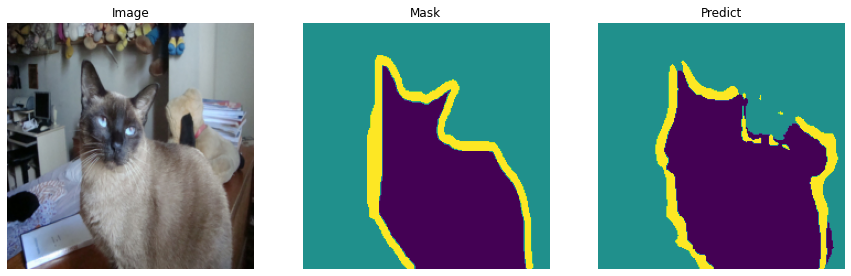

Validation loss decreased (0.294907 --> 0.247932).  Saving model ...
 Epoch: [11/30] - Train
Current Step: 50 	Train Loss: 0.21727848827838897, Train Iou: 0.8788594007492065
Current Step: 100 	Train Loss: 0.2203404825925827, Train Iou: 0.8773335218429565
Current Step: 150 	Train Loss: 0.19629803240299226, Train Iou: 0.8844552040100098
Current Step: 200 	Train Loss: 0.20572603344917298, Train Iou: 0.8823937177658081
 Epoch: [11/30] - Validation
Validation step: Val Loss: 0.2373848557472229, Val Iou: 0.8710654973983765


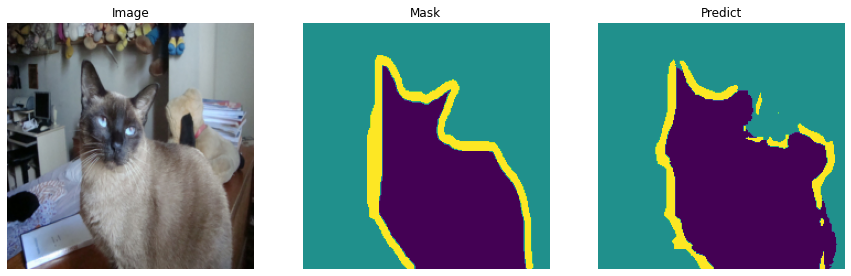

Validation loss decreased (0.247932 --> 0.237385).  Saving model ...
 Epoch: [12/30] - Train
Current Step: 50 	Train Loss: 0.20478143095970153, Train Iou: 0.884219765663147
Current Step: 100 	Train Loss: 0.19273511528968812, Train Iou: 0.8875916004180908
Current Step: 150 	Train Loss: 0.17913687467575073, Train Iou: 0.8904822468757629
Current Step: 200 	Train Loss: 0.20090110659599303, Train Iou: 0.8870764374732971
 Epoch: [12/30] - Validation
Validation step: Val Loss: 0.24645790457725525, Val Iou: 0.8617944121360779


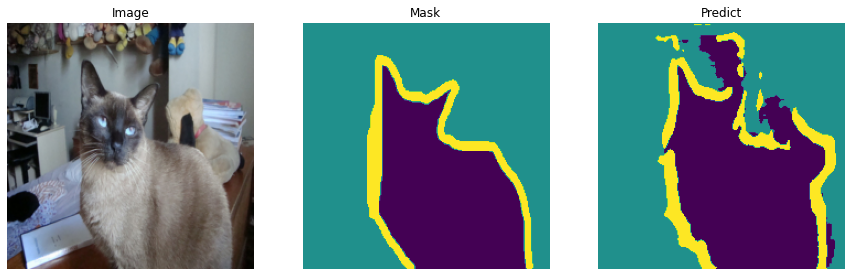

EarlyStopping counter: 1 out of 7
 Epoch: [13/30] - Train
Current Step: 50 	Train Loss: 0.17990638375282286, Train Iou: 0.8915185332298279
Current Step: 100 	Train Loss: 0.19164686799049377, Train Iou: 0.8897592425346375
Current Step: 150 	Train Loss: 0.18614475905895234, Train Iou: 0.8910232782363892
Current Step: 200 	Train Loss: 0.17055466681718826, Train Iou: 0.8962723612785339
 Epoch: [13/30] - Validation
Validation step: Val Loss: 0.22199122607707977, Val Iou: 0.888961136341095


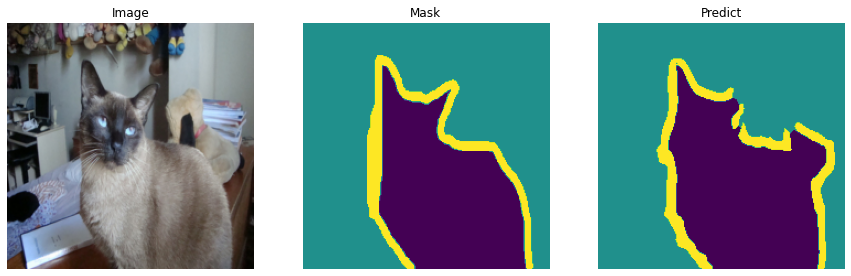

Validation loss decreased (0.237385 --> 0.221991).  Saving model ...
 Epoch: [14/30] - Train
Current Step: 50 	Train Loss: 0.17923736572265625, Train Iou: 0.8946285247802734
Current Step: 100 	Train Loss: 0.1653558361530304, Train Iou: 0.8992046117782593
Current Step: 150 	Train Loss: 0.16856058776378632, Train Iou: 0.8973352909088135
Current Step: 200 	Train Loss: 0.16520809650421142, Train Iou: 0.8986603617668152
 Epoch: [14/30] - Validation
Validation step: Val Loss: 0.1824263036251068, Val Iou: 0.8986890912055969


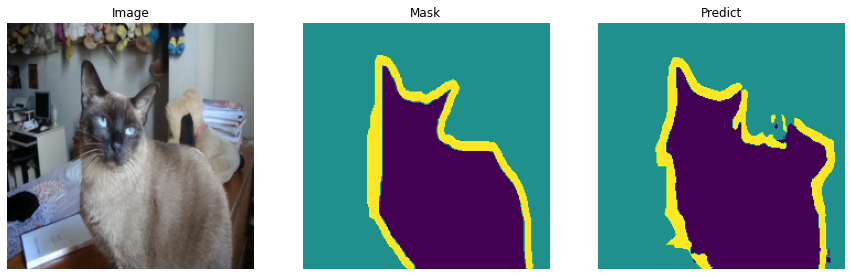

Validation loss decreased (0.221991 --> 0.182426).  Saving model ...
 Epoch: [15/30] - Train
Current Step: 50 	Train Loss: 0.14440062165260314, Train Iou: 0.9069166779518127
Current Step: 100 	Train Loss: 0.15334583431482315, Train Iou: 0.9049715995788574
Current Step: 150 	Train Loss: 0.14247260004281997, Train Iou: 0.9086112976074219
Current Step: 200 	Train Loss: 0.16742598444223403, Train Iou: 0.9003349542617798
 Epoch: [15/30] - Validation
Validation step: Val Loss: 0.2248438447713852, Val Iou: 0.8853909373283386


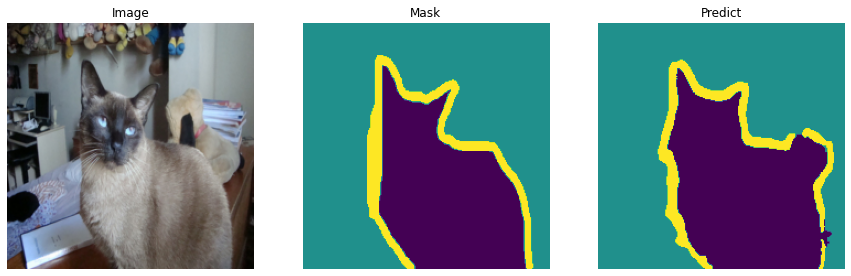

EarlyStopping counter: 1 out of 7
 Epoch: [16/30] - Train
Current Step: 50 	Train Loss: 0.15072883546352386, Train Iou: 0.9041149616241455
Current Step: 100 	Train Loss: 0.15713318437337875, Train Iou: 0.9048988223075867
Current Step: 150 	Train Loss: 0.12641276448965072, Train Iou: 0.9138651490211487
Current Step: 200 	Train Loss: 0.1498844063282013, Train Iou: 0.9059826135635376
 Epoch: [16/30] - Validation
Validation step: Val Loss: 0.17352409660816193, Val Iou: 0.8987783193588257


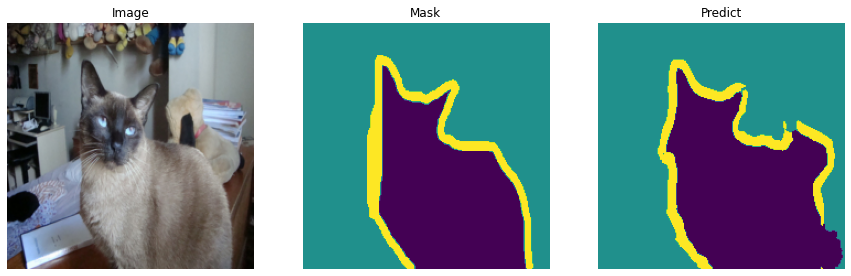

Validation loss decreased (0.182426 --> 0.173524).  Saving model ...
 Epoch: [17/30] - Train
Current Step: 50 	Train Loss: 0.134348609149456, Train Iou: 0.9150018095970154
Current Step: 100 	Train Loss: 0.1308342310786247, Train Iou: 0.9143648743629456
Current Step: 150 	Train Loss: 0.12110753178596496, Train Iou: 0.9150061011314392
Current Step: 200 	Train Loss: 0.13659344404935836, Train Iou: 0.9112879037857056
 Epoch: [17/30] - Validation
Validation step: Val Loss: 0.18979774415493011, Val Iou: 0.8995185494422913


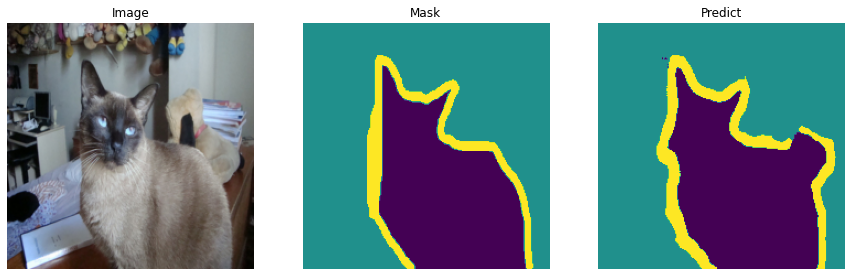

EarlyStopping counter: 1 out of 7
 Epoch: [18/30] - Train
Current Step: 50 	Train Loss: 0.11097600668668747, Train Iou: 0.9185196757316589
Current Step: 100 	Train Loss: 0.12461683571338654, Train Iou: 0.9186844825744629
Current Step: 150 	Train Loss: 0.1164347204566002, Train Iou: 0.920116126537323
Current Step: 200 	Train Loss: 0.1099081939458847, Train Iou: 0.9209911823272705
 Epoch: [18/30] - Validation
Validation step: Val Loss: 0.2135034054517746, Val Iou: 0.8739361763000488


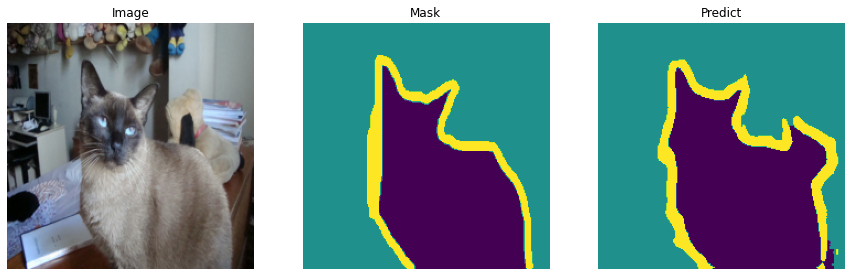

EarlyStopping counter: 2 out of 7
 Epoch: [19/30] - Train
Current Step: 50 	Train Loss: 0.11521757304668427, Train Iou: 0.9204965233802795
Current Step: 100 	Train Loss: 0.10117935240268708, Train Iou: 0.9264025092124939
Current Step: 150 	Train Loss: 0.10516474425792693, Train Iou: 0.9238430857658386
Current Step: 200 	Train Loss: 0.1038979822397232, Train Iou: 0.9244602918624878
 Epoch: [19/30] - Validation
Validation step: Val Loss: 0.17057538032531738, Val Iou: 0.8969981670379639


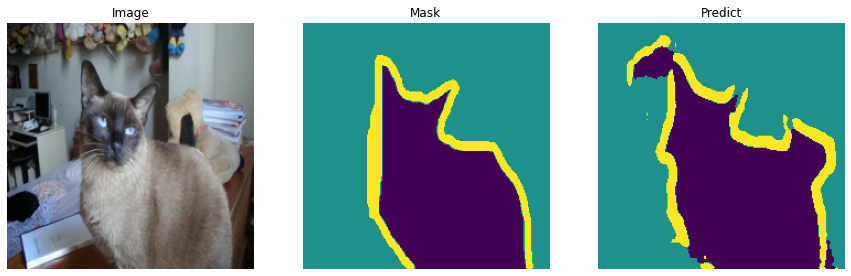

Validation loss decreased (0.173524 --> 0.170575).  Saving model ...
 Epoch: [20/30] - Train
Current Step: 50 	Train Loss: 0.10151919037103653, Train Iou: 0.9274001121520996
Current Step: 100 	Train Loss: 0.09230831056833268, Train Iou: 0.9294843077659607
Current Step: 150 	Train Loss: 0.08751824676990509, Train Iou: 0.9278776049613953
Current Step: 200 	Train Loss: 0.0997177255153656, Train Iou: 0.9277843236923218
 Epoch: [20/30] - Validation
Validation step: Val Loss: 0.19324906170368195, Val Iou: 0.8893282413482666


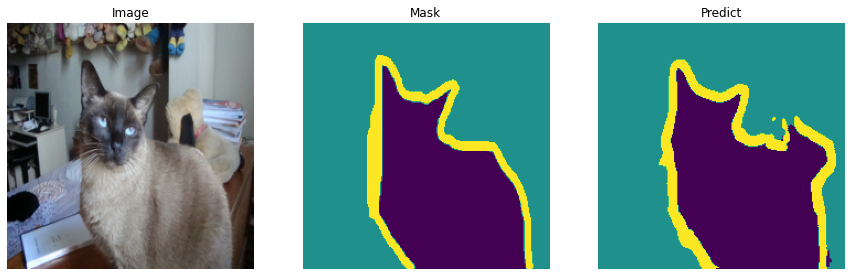

EarlyStopping counter: 1 out of 7
 Epoch: [21/30] - Train
Current Step: 50 	Train Loss: 0.07804108798503875, Train Iou: 0.9332240223884583
Current Step: 100 	Train Loss: 0.08974019765853881, Train Iou: 0.9302247762680054
Current Step: 150 	Train Loss: 0.07544921368360519, Train Iou: 0.9371269345283508
Current Step: 200 	Train Loss: 0.09069023966789246, Train Iou: 0.9297884106636047
 Epoch: [21/30] - Validation
Validation step: Val Loss: 0.15699152648448944, Val Iou: 0.9052637815475464


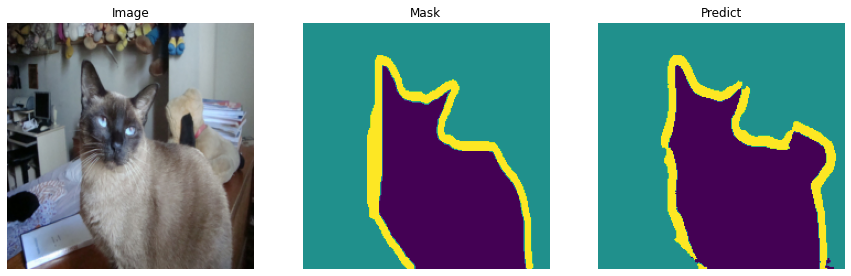

Validation loss decreased (0.170575 --> 0.156992).  Saving model ...
 Epoch: [22/30] - Train
Current Step: 50 	Train Loss: 0.07805646121501923, Train Iou: 0.935657262802124
Current Step: 100 	Train Loss: 0.08766457051038742, Train Iou: 0.9330071210861206
Current Step: 150 	Train Loss: 0.08468381375074387, Train Iou: 0.9314852952957153
Current Step: 200 	Train Loss: 0.05947601556777954, Train Iou: 0.9384344220161438
 Epoch: [22/30] - Validation
Validation step: Val Loss: 0.1811128705739975, Val Iou: 0.9046631455421448


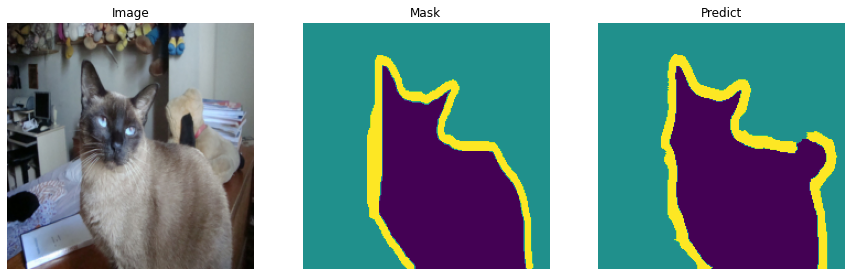

EarlyStopping counter: 1 out of 7
 Epoch: [23/30] - Train
Current Step: 50 	Train Loss: 0.06672532171010971, Train Iou: 0.9394782781600952
Current Step: 100 	Train Loss: 0.06253241151571273, Train Iou: 0.9391059875488281
Current Step: 150 	Train Loss: 0.07133192479610444, Train Iou: 0.9365184307098389
Current Step: 200 	Train Loss: 0.07184011429548263, Train Iou: 0.9383105635643005
 Epoch: [23/30] - Validation
Validation step: Val Loss: 0.18292178213596344, Val Iou: 0.9028902053833008


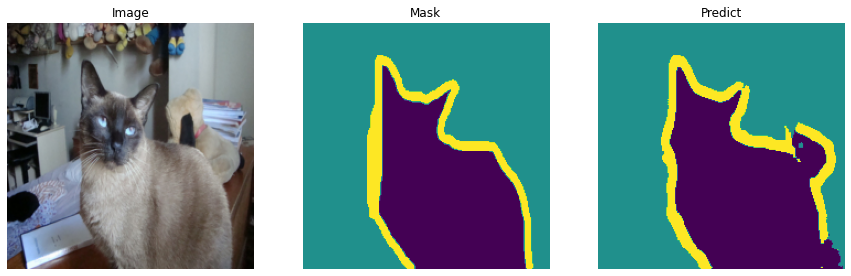

EarlyStopping counter: 2 out of 7
 Epoch: [24/30] - Train
Current Step: 50 	Train Loss: 0.04655142962932587, Train Iou: 0.9452674388885498
Current Step: 100 	Train Loss: 0.05015713065862656, Train Iou: 0.9448245763778687
Current Step: 150 	Train Loss: 0.04771706759929657, Train Iou: 0.9436031579971313
Current Step: 200 	Train Loss: 0.06688652157783509, Train Iou: 0.9421239495277405
 Epoch: [24/30] - Validation
Validation step: Val Loss: 0.1773102879524231, Val Iou: 0.9019203782081604


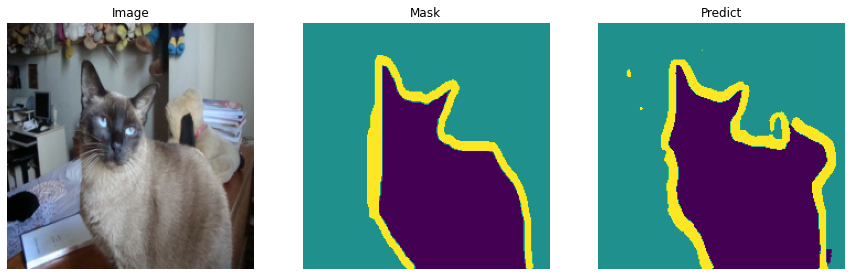

EarlyStopping counter: 3 out of 7
 Epoch: [25/30] - Train
Current Step: 50 	Train Loss: 0.04453191667795181, Train Iou: 0.947934091091156
Current Step: 100 	Train Loss: 0.04036723732948303, Train Iou: 0.9481057524681091
Current Step: 150 	Train Loss: 0.050648164749145505, Train Iou: 0.9458452463150024
Current Step: 200 	Train Loss: 0.04178323924541474, Train Iou: 0.9463838338851929
 Epoch: [25/30] - Validation
Validation step: Val Loss: 0.2023397535085678, Val Iou: 0.9025858044624329


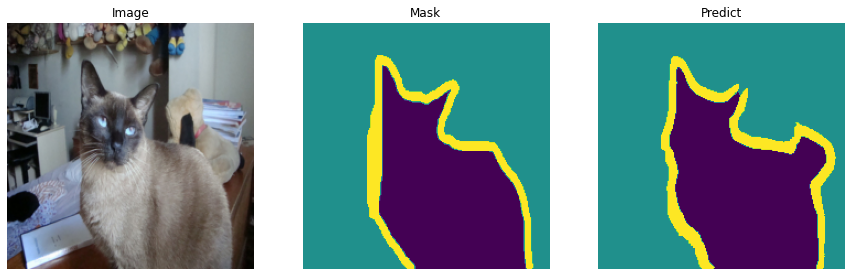

EarlyStopping counter: 4 out of 7
 Epoch: [26/30] - Train
Current Step: 50 	Train Loss: 0.036551046371459964, Train Iou: 0.9485012888908386
Current Step: 100 	Train Loss: 0.03197911828756332, Train Iou: 0.9503708481788635
Current Step: 150 	Train Loss: 0.03487941920757294, Train Iou: 0.9482430219650269
Current Step: 200 	Train Loss: 0.06478168368339539, Train Iou: 0.9432941675186157
 Epoch: [26/30] - Validation
Validation step: Val Loss: 0.17530842125415802, Val Iou: 0.9123557209968567


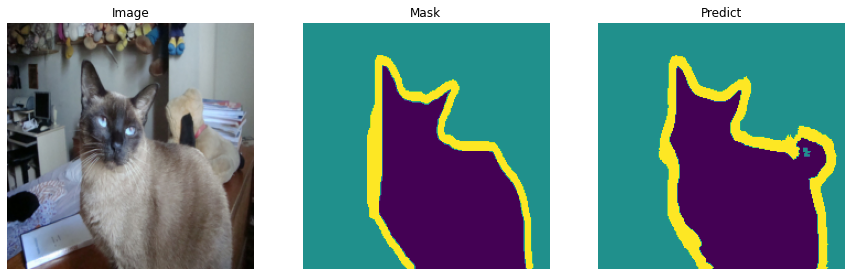

EarlyStopping counter: 5 out of 7
 Epoch: [27/30] - Train
Current Step: 50 	Train Loss: 0.04757871747016907, Train Iou: 0.9491701722145081
Current Step: 100 	Train Loss: 0.03495378911495209, Train Iou: 0.9511845111846924
Current Step: 150 	Train Loss: 0.03155089020729065, Train Iou: 0.9498109221458435
Current Step: 200 	Train Loss: 0.03280372887849808, Train Iou: 0.9471578001976013
 Epoch: [27/30] - Validation
Validation step: Val Loss: 0.1613815724849701, Val Iou: 0.9130911231040955


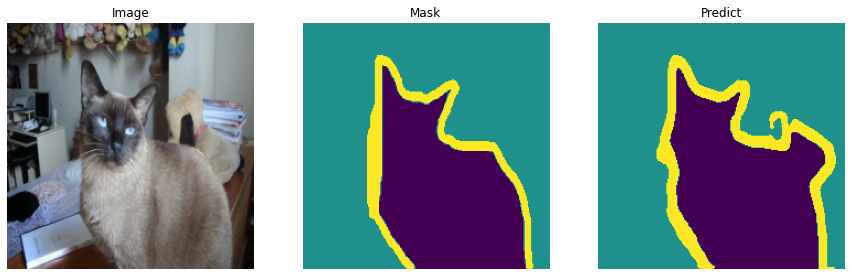

EarlyStopping counter: 6 out of 7
 Epoch: [28/30] - Train
Current Step: 50 	Train Loss: 0.023809411823749543, Train Iou: 0.9524760246276855
Current Step: 100 	Train Loss: 0.027202209234237672, Train Iou: 0.9533036947250366
Current Step: 150 	Train Loss: 0.030120996534824373, Train Iou: 0.9527625441551208
Current Step: 200 	Train Loss: 0.02008738100528717, Train Iou: 0.9548802971839905
 Epoch: [28/30] - Validation
Validation step: Val Loss: 0.1704113483428955, Val Iou: 0.915008544921875


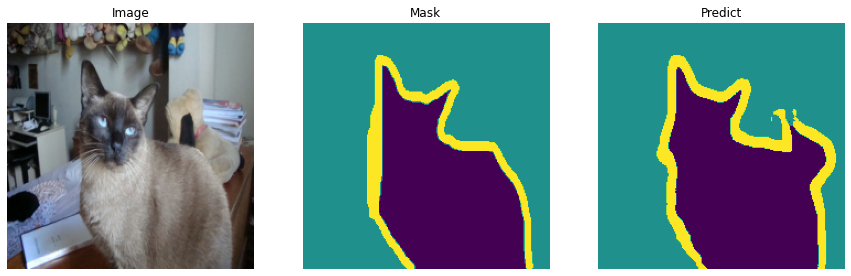

EarlyStopping counter: 7 out of 7


In [19]:
train_result = []
val_result = []

early_stopper = EarlyStopping(
    patience=7, verbose=True, path=os.path.join(model_path, "model.ckpt")
)


for epoch in range(1, epochs + 1):
    train_loss, train_iou = train(epoch, model, train_loader, loss_fn, optimizer)
    val_loss, val_iou = validation(epoch, model, val_loader, loss_fn)
    
    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        break

    train_result.append([train_loss, train_iou])
    val_result.append([val_loss, val_iou])

# Visualization Loss & IOU

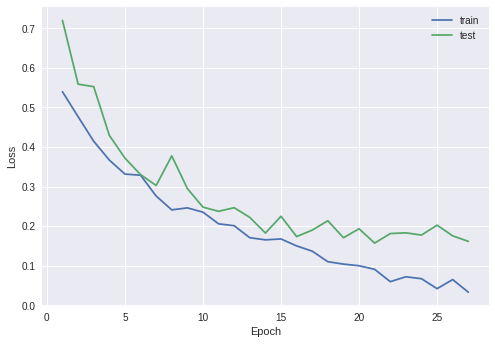

In [20]:
plt.style.use('seaborn')
plt.plot([i for i in range(1, len(train_result) + 1)], [i[0] for i in train_result])
plt.plot([i for i in range(1, len(val_result) + 1)], [i[0] for i in val_result])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"])
plt.show()

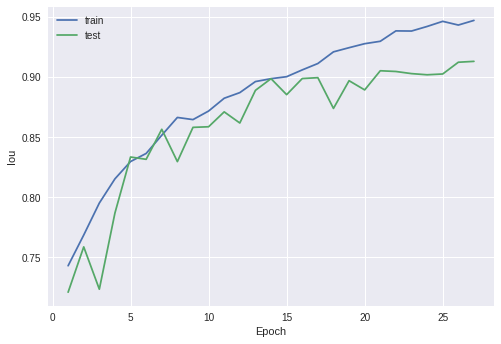

In [21]:
plt.plot([i for i in range(1, len(train_result) + 1)], [i[1] for i in train_result])
plt.plot([i for i in range(1, len(val_result) + 1)], [i[1] for i in val_result])
plt.xlabel("Epoch")
plt.ylabel("Iou")
plt.legend(["train", "test"])
plt.show()

# Test Model

Test Iou:  tensor(0.8139)


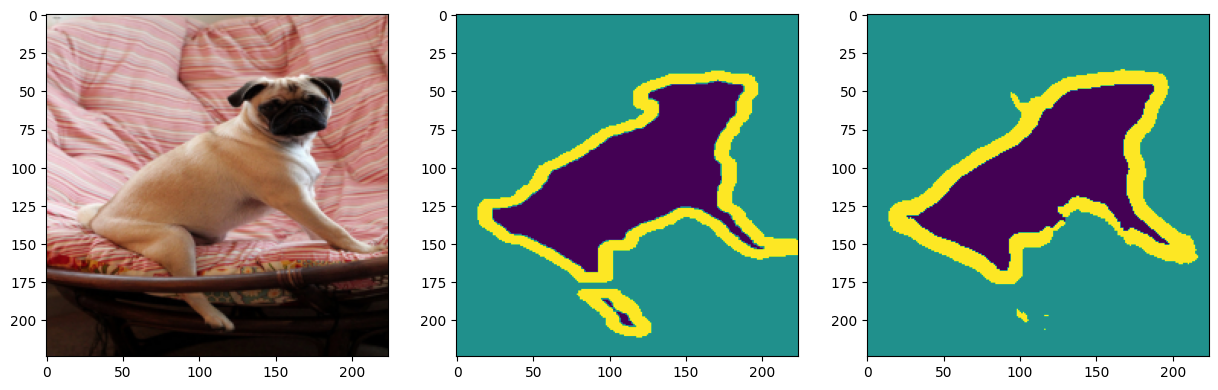

In [27]:
image, mask = next(iter(val_loader))
img, msk = image[7], mask[7]

plt.style.use('default')
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(torch.permute(img, (1, 2, 0)))
plt.subplot(132)


msk = torch.squeeze(msk, 0)
plt.imshow(msk)

model.eval()
out = model(torch.unsqueeze(img, 0).to(device))
print('Test Iou: ', iou(out, msk))

out = F.softmax(out, 1)
out = torch.squeeze(out, 0)
_, out = torch.max(out, 0)


plt.subplot(133)
plt.imshow(out.detach().cpu().numpy())
plt.show()